In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as pd
import pandas as pd
import cv2
import pydicom
import scipy

from sklearn.model_selection import train_test_split, StratifiedKFold
from matplotlib import pyplot as plt
from utils.mask_functions import *
from glob import glob
from PIL import Image
from scipy.sparse import load_npz
from keras_tqdm import TQDMNotebookCallback
from tqdm import tqdm_notebook

import tensorflow as tf
import keras
from keras.applications.resnet50 import ResNet50
from keras_applications.resnext import ResNeXt50
from keras.utils import Sequence
from keras.preprocessing.image import load_img
from keras.models import Model, model_from_json
from keras.layers import Input, ReLU, LeakyReLU, core, Dropout, BatchNormalization, Concatenate, Dense, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, Callback
from keras.losses import binary_crossentropy
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
# Restrict to single GPU
os.environ["CUDA_VISIBLE_DEVICES"]='3'

### Parse Data - Create Annotations

In [3]:
train_path = './siim/dicom-images-train/*/*/*.dcm'
mask_path = './siim/train-rle.csv'
imgs_to_ram = True # Low or high memory usage
mask_imgs = True # Load masks to df
img_height = 512
img_width = 512
n_channels = 1
batch_size = 8
epochs = 500

In [4]:
def get_train_df(train_path=train_path, mask_path=mask_path, imgs_to_ram=False, mask_imgs=False):
    rles_df = pd.read_csv(mask_path)
    rles_df.columns = ['ImageId', 'EncodedPixels']
        
    metadata_list = []
    train_fps = glob(train_path)

    if imgs_to_ram is True:
        img_dict = {}
    for i, fp in tqdm_notebook(enumerate(train_fps)):
        metadata = {}
        dcm = pydicom.dcmread(fp)
        metadata['ImageId'] = dcm.SOPInstanceUID
        metadata['FilePath'] = fp
        
        encoded_pixels_list = rles_df[rles_df['ImageId']==dcm.SOPInstanceUID]['EncodedPixels'].values
        pneumothorax = False
        for encoded_pixels in encoded_pixels_list:
            if encoded_pixels != ' -1':
                pneumothorax = True
        
        metadata['Pneumothorax'] = pneumothorax
        
        if imgs_to_ram is True:
            metadata['PixelArray'] = dcm.pixel_array
            if mask_imgs is True:
                if pneumothorax is True:
                    metadata['EncodedPixels'] = load_npz('siim/mask/'+dcm.SOPInstanceUID+'.npz').todense().astype('uint8')
                else:
                    metadata['EncodedPixels'] = np.zeros((1024, 1024))
                
        metadata_list.append(metadata)

    return pd.DataFrame(metadata_list)

In [5]:
df = get_train_df(train_path, mask_path, imgs_to_ram=imgs_to_ram, mask_imgs=mask_imgs)

In [6]:
df.head()

,ImageId,FilePath,Pneumothorax,PixelArray,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.31935.15178751...,./siim/dicom-images-train/1.2.276.0.7230010.3....,False,"[[1, 2, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1.2.276.0.7230010.3.1.4.8323329.4297.151787518...,./siim/dicom-images-train/1.2.276.0.7230010.3....,True,"[[1, 0, 1, 0, 0, 3, 0, 0, 2, 1, 1, 0, 0, 0, 0,...","[[[[[0 0 0 ... 0 0 0]]]], [[[[0 0 0 ... 0 0 0]..."
2,1.2.276.0.7230010.3.1.4.8323329.12953.15178752...,./siim/dicom-images-train/1.2.276.0.7230010.3....,False,"[[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1.2.276.0.7230010.3.1.4.8323329.12901.15178752...,./siim/dicom-images-train/1.2.276.0.7230010.3....,False,"[[86, 87, 88, 88, 88, 88, 87, 86, 86, 86, 86, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,1.2.276.0.7230010.3.1.4.8323329.12036.15178752...,./siim/dicom-images-train/1.2.276.0.7230010.3....,False,"[[153, 139, 123, 107, 94, 84, 75, 65, 57, 52, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


### Split and Balance the Data

In [7]:
# Imbalance between Pos and Neg classifications:
len(df[df.Pneumothorax == True]), len(df[df.Pneumothorax == False])

(2379, 8296)

In [8]:
# Balance
balanced_df = pd.concat([df[df.Pneumothorax == True], df[df.Pneumothorax == False][:2379]])

In [9]:
# Imbalance between Pos and Neg classifications:
len(balanced_df[balanced_df.Pneumothorax == True]), len(balanced_df[balanced_df.Pneumothorax == False])

(2379, 2379)

In [10]:
train_df, val_df = train_test_split(balanced_df, stratify=balanced_df.Pneumothorax, test_size=0.1, random_state=88)

In [11]:
len(train_df), len(val_df)

(4282, 476)

img_height = 1024
img_width = 1024
batch_size = 16

In [12]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, data_frame,
                 batch_size=4,
                 img_height=512,
                 img_width=512,
                 n_channels=3,
                 augmentations=None,
                 mask_imgs=False,
                 train=True,
                 shuffle=True):
        self.data_frame = data_frame
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.n_channels = n_channels
        self.augment = augmentations
        self.mask_imgs = mask_imgs
        self.train = train
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        'Batches per epoch'
        return int(np.ceil(len(self.data_frame) / self.batch_size))
    
    def on_epoch_end(self):
        'Update indexes when epoch ends'
        self.indexes = np.arange(len(self.data_frame))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        'Get one batch'
        batch_indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.data_frame))]
        
        if self.train is True:
            batch_x, batch_y = self.data_generation(batch_indexes)
            
            if self.augment is None:
                return np.expand_dims(batch_x[:,:,:,0], axis=3), np.expand_dims(batch_y, axis=3)
            
            imgs, masks = [], []
            for x, y in zip(batch_x, batch_y):
                augmented = self.augment(image=x, mask=y)
                imgs.append(augmented['image'])
                masks.append(augmented['mask'])

            imgs = np.expand_dims(np.array(imgs)[:,:,:,0], axis=3)
            masks = np.expand_dims(np.array(masks), axis=3)
            
            return imgs, masks
        else:
            batch_x = self.data_generation(batch_indexes)
            
            if self.augment is None:
                return np.expand_dims(batch_x[:,:,:,0], axis=3)
            
            return np.expand_dims(np.stack([self.augment(image=x)['image'] for x in batch_x], axis=0)[:,:,:,0], axis=3)
        
    def data_generation(self, batch_indexes):
        if 'PixelArray' in self.data_frame.columns:
            X = [cv2.resize(img, (self.img_height, self.img_width)) for img in self.data_frame.iloc[batch_indexes]['PixelArray']]
        else:   
            fps = self.data_frame.iloc[batch_indexes].FilePath
            X = np.empty((len(fps), self.img_height, self.img_width))
            for i, fp in enumerate(fps):
                dcm = pydicom.dcmread(fp)
                X[i] = cv2.resize(dcm.pixel_array, (self.img_height, self.img_width))
        # Gray img to rgb
        X = np.array(np.stack([X, X, X], axis=3))
        
        if self.train is False:
            return np.uint8(X)

        if self.mask_imgs is False:
            Y = pd.concat([np.invert(self.data_frame.iloc[batch_indexes]['Pneumothorax'])+0,
                           self.data_frame.iloc[batch_indexes]['Pneumothorax']+0],
                           axis=1)
            Y = np.array(Y)
        else:
            Y = [cv2.resize(img, (self.img_height, self.img_width)) for img in self.data_frame.iloc[batch_indexes]['EncodedPixels']]
            Y = np.array(Y)
            Y[Y > 0] = 1.            

        return np.uint8(X), np.uint8(Y)

In [13]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate, GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, GaussNoise, CenterCrop,
    IAAAdditiveGaussianNoise, GaussNoise, RandomSizedCrop
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    RandomBrightness(p=0.5),
    ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.1,
        rotate_limit=10,
        border_mode=cv2.BORDER_CONSTANT,
        p=0.5
    ),
    RandomSizedCrop(min_max_height=(int(0.95*img_height), img_height), height=img_height, width=img_width, p=0.5),
    CLAHE(),
    ToFloat()
], p=1)


AUGMENTATIONS_TEST = Compose([
    CLAHE(),
    ToFloat()
], p=1)

### Check Augmentations

In [14]:
def plot_pixel_array(data, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(data, cmap=plt.cm.bone)
    plt.show()
    
def plot_pixel_array_overlay(data, label, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(data, cmap=plt.cm.bone)
    plt.imshow(label, alpha=.3)
    plt.show()
    
def plot_grid(imgs, grid_width, grid_height):
    max_imgs = grid_width*grid_height
    plt.clf()
    fig, axes = plt.subplots(grid_height, grid_width, figsize=(16, 12))
    
    for i, img in zip(range(max_imgs), imgs):
        ax = axes[int(i/grid_width), i%grid_width]
        ax.imshow(img, cmap='bone')
        ax.axis('off')
    
    plt.show()
    
def plot_grid_overlay(imgs, masks, grid_width, grid_height):
    max_imgs = grid_width*grid_height
    plt.clf()
    fig, axes = plt.subplots(grid_height, grid_width, figsize=(16, 12))
    
    for i, img, mask in zip(range(max_imgs), imgs, masks):
        ax = axes[int(i/grid_width), i%grid_width]
        ax.imshow(img, cmap='bone')
        ax.imshow(mask, alpha=0.4)
        ax.axis('off')
    
    plt.show()

0 245 (20, 512, 512, 1) (512, 512, 1)
0 1 (20, 512, 512, 1) (512, 512, 1)


<Figure size 432x288 with 0 Axes>

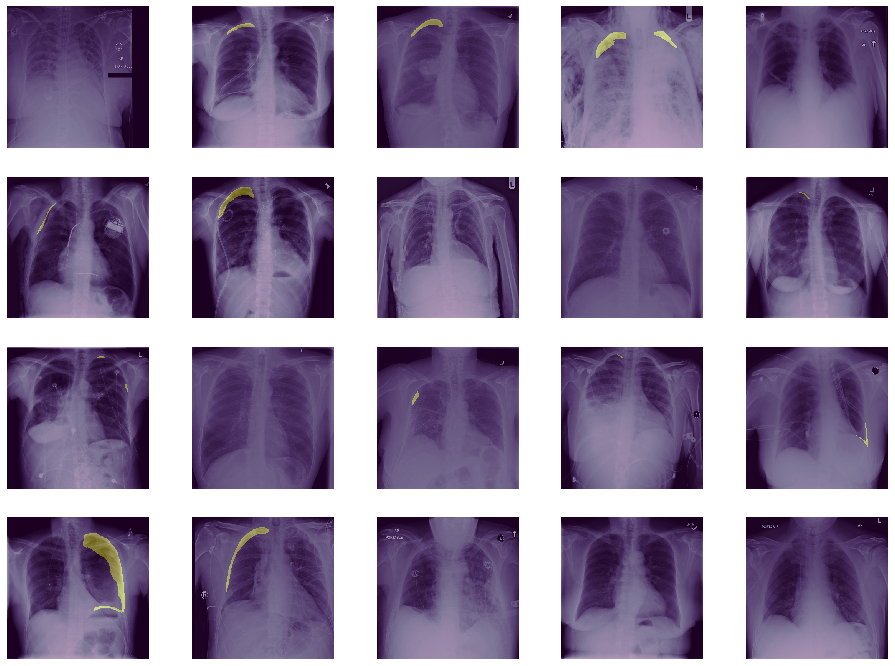

In [15]:
a = DataGenerator(data_frame=train_df, batch_size=20, shuffle=False,
                 img_height=img_height, img_width=img_width, n_channels=n_channels, mask_imgs=mask_imgs)
imgs, masks = a.__getitem__(0)
print(imgs[1].min(), imgs[1].max(), imgs.shape, imgs[0].shape)
print(masks[1].min(), masks[1].max(), masks.shape, masks[0].shape)
plot_grid_overlay(imgs.squeeze(), masks.squeeze(), 5, 4)

0.0 0.85490197 (20, 512, 512, 1) (512, 512, 1)
0 1 (20, 512, 512, 1) (512, 512, 1)


<Figure size 432x288 with 0 Axes>

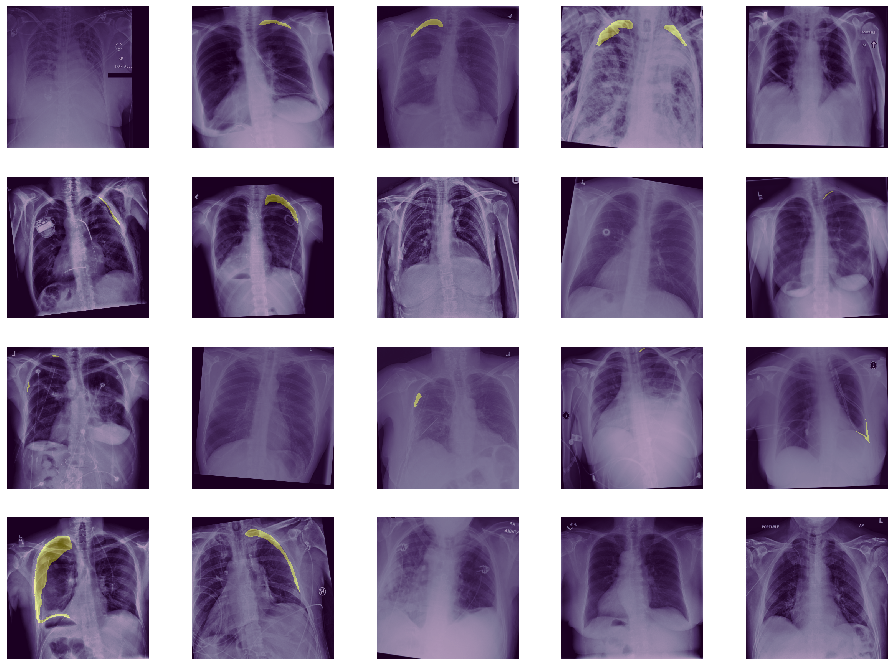

In [16]:
# Augmented
b = DataGenerator(data_frame=train_df, batch_size=20, augmentations=AUGMENTATIONS_TRAIN, shuffle=False,
                 img_height=img_height, img_width=img_width, n_channels=n_channels, mask_imgs=mask_imgs)
imgs, masks = b.__getitem__(0)
print(imgs[1].min(), imgs[1].max(), imgs.shape, imgs[0].shape)
print(masks[1].min(), masks[1].max(), masks.shape, masks[0].shape)
plot_grid_overlay(imgs.squeeze(), masks.squeeze(), 5, 4)

0.0 0.9607843 (20, 512, 512, 1) (512, 512, 1)
0 1 (20, 512, 512, 1) (512, 512, 1)


<Figure size 432x288 with 0 Axes>

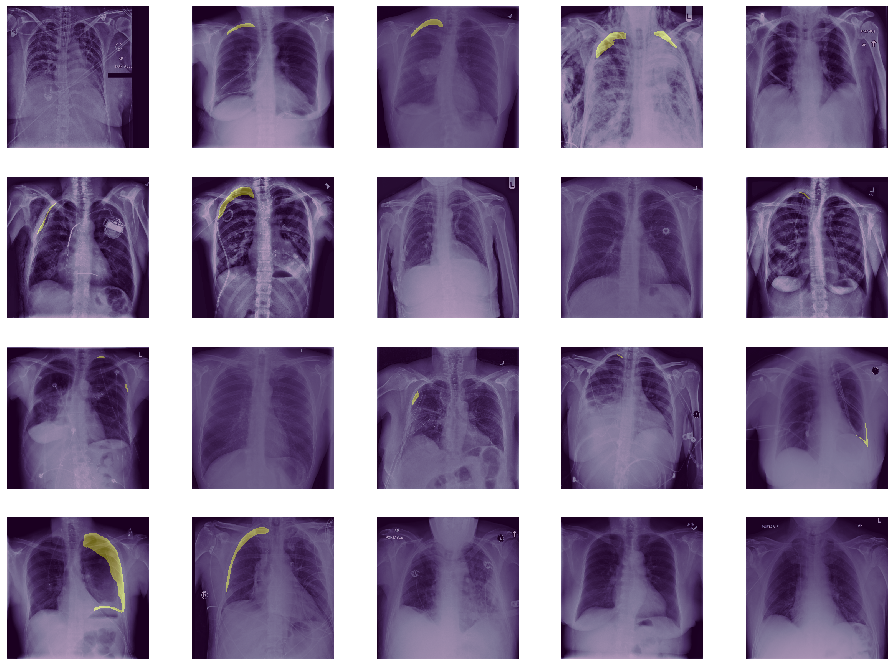

In [17]:
# Test Time Augmentations
b = DataGenerator(data_frame=train_df, batch_size=20, augmentations=AUGMENTATIONS_TEST, shuffle=False,
                 img_height=img_height, img_width=img_width, n_channels=n_channels, mask_imgs=mask_imgs)
imgs, masks = b.__getitem__(0)
print(imgs[1].min(), imgs[1].max(), imgs.shape, imgs[0].shape)
print(masks[1].min(), masks[1].max(), masks.shape, masks[0].shape)
plot_grid_overlay(imgs.squeeze(), masks.squeeze(), 5, 4)

### Define Loss

In [18]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [19]:
# https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/
def focal_loss(alpha=0.25, gamma=2):
  def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
    weight_a = alpha * (1 - y_pred) ** gamma * targets
    weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
    
    return (tf.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b 

  def loss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.log(y_pred / (1 - y_pred))

    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)

    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss)

  return loss

def focal_dice_loss(y_true, y_pred):
    f_loss = focal_loss()
    return f_loss(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_focal_dice_loss(y_true, y_pred):
    f_loss = focal_loss()
    return binary_crossentropy(y_true, y_pred) + f_loss(y_true, y_pred) + dice_loss(y_true, y_pred)

### Build Model

In [20]:
def block(inputs, f_size, d=0.2):
    c1 = Conv2D(f_size, (3, 3), padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = LeakyReLU(alpha=0.1)(c1)
    c1 = Dropout(d)(c1)
    
    c2 = Conv2D(f_size, (3, 3), padding='same')(c1)
    c2 = BatchNormalization()(c2)
    c2 = LeakyReLU(alpha=0.1)(c2)
    c2 = Dropout(d)(c2)
    
    return c2
    
def unet(img_height=img_height, img_width=img_width, n_channels=n_channels):  
    inputs = Input(shape=(img_height, img_width, n_channels))
    
    b1 = block(inputs, 16)
    c1_s = Conv2D(16, (3, 3), strides=2, padding='same')(b1)
    c1_s = LeakyReLU(alpha=0.1)(c1_s)
    
    b2 = block(c1_s, 32)
    c2_s = Conv2D(32, (3, 3), strides=2, padding='same')(b2)
    c2_s = LeakyReLU(alpha=0.1)(c2_s)
    
    b3 = block(c2_s, 64)
    c3_s = Conv2D(64, (3, 3), strides=2, padding='same')(b3)
    c3_s = LeakyReLU(alpha=0.1)(c3_s)
    
    b4 = block(c3_s, 128)
    c4_s = Conv2D(128, (3, 3), strides=2, padding='same')(b4)
    c4_s = LeakyReLU(alpha=0.1)(c4_s)
    
    b5 = block(c4_s, 256)
    
    t1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b5)
    t1 = Concatenate(axis=3)([t1, b4])
    db1 = block(t1, 128)
    
    t2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(db1)
    t2 = Concatenate(axis=3)([t2, b3])
    db2 = block(t2, 64)
    
    t3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(db2)
    t3 = Concatenate(axis=3)([t3, b2])
    db3 = block(t3, 32)
    
    t4 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(db3)
    t4 = Concatenate(axis=3)([t4, b1])
    db4 = block(t4, 16)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(db4)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [21]:
K.clear_session()
model = unet(img_height, img_width, n_channels)
model_name = 'unet'
#model = get_resnet50_unet(tail_block=True)
model.summary()

try:
    os.mkdir('./save/'+model_name)
except Exception:
    pass

W0827 20:45:02.564025 140194736273152 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0827 20:45:02.564881 140194736273152 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0827 20:45:02.581588 140194736273152 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 20:45:02.582653 140194736273152 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W082

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 512, 512, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 

In [22]:
class SWA(Callback):
    
    def __init__(self, swa_epoch):
        super(SWA, self).__init__()
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights('./save/'+model_name+'/'+model_name+'_LAST.h5', overwrite=True)
        print('Final stochastic averaged weights saved to file.')

In [23]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            ModelCheckpoint('./save/'+model_name+'/'+model_name+'_BEST.h5',
                            monitor='val_dice_loss',
                            mode='min',
                            verbose=1,
                            save_best_only=True,
                            save_weights_only=True),
            SWA(60),
            LearningRateScheduler(schedule=self._cosine_anneal_schedule),
            EarlyStopping(patience=25)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

In [24]:
'''
checkpointer = ModelCheckpoint('./save/'+model_name+'/'+model_name+'_BEST.h5', monitor='val_dice_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=True)
earlystopping = EarlyStopping(patience=25)
'''
opt = Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.00001)

In [25]:
model.compile(optimizer=opt, loss=[bce_dice_loss], metrics=[dice_loss])
with open('./save/'+model_name+'/'+model_name+'_ARCHITECTURE.json', 'w') as f:
    f.write(model.to_json())

W0827 20:45:06.064583 140194736273152 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0827 20:45:06.074677 140194736273152 deprecation.py:323] From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
snapshot = SnapshotCallbackBuilder(nb_epochs=epochs, nb_snapshots=1, init_lr=0.1)
training_generator = DataGenerator(data_frame=train_df,
                                   img_height=img_height,
                                   img_width=img_width,
                                   n_channels=n_channels,
                                   batch_size=batch_size,
                                   mask_imgs=mask_imgs,
                                   train=True,
                                   augmentations=AUGMENTATIONS_TRAIN)
validation_generator = DataGenerator(data_frame=val_df,
                                     img_height=img_height,
                                     img_width=img_width,
                                     n_channels=n_channels,
                                     batch_size=batch_size,
                                     mask_imgs=mask_imgs,
                                     train=True,
                                     augmentations=AUGMENTATIONS_TEST)
history = model.fit_generator(generator=training_generator,
                              validation_data=validation_generator,
                              use_multiprocessing=False,
                              epochs=epochs,
                              verbose=1,
                              callbacks=snapshot.get_callbacks())

Stochastic weight averaging selected for last 440 epochs.
Epoch 1/500
536/536 [==============================] - 193s 359ms/step - loss: 1.0351 - dice_loss: 0.9706 - dice_coef: nan - val_loss: 11.3241 - val_dice_loss: 0.9840 - val_dice_coef: 0.0160

Epoch 00001: val_dice_loss improved from inf to 0.98400, saving model to ./save/unet/unet_BEST.h5
Epoch 2/500
536/536 [==============================] - 174s 324ms/step - loss: 0.9583 - dice_loss: 0.8994 - dice_coef: 0.1145 - val_loss: 1.0168 - val_dice_loss: 0.9569 - val_dice_coef: 0.0495

Epoch 00002: val_dice_loss improved from 0.98400 to 0.95689, saving model to ./save/unet/unet_BEST.h5
Epoch 3/500
536/536 [==============================] - 157s 292ms/step - loss: 0.9288 - dice_loss: 0.8700 - dice_coef: 0.1442 - val_loss: 0.9644 - val_dice_loss: 0.9200 - val_dice_coef: 0.0829

Epoch 00003: val_dice_loss improved from 0.95689 to 0.91997, saving model to ./save/unet/unet_BEST.h5
Epoch 4/500
536/536 [==============================] - 157s 

536/536 [==============================] - 239s 446ms/step - loss: 0.7604 - dice_loss: 0.7096 - dice_coef: 0.3022 - val_loss: 0.8314 - val_dice_loss: 0.7788 - val_dice_coef: 0.2276

Epoch 00031: val_dice_loss did not improve from 0.73481
Epoch 32/500
536/536 [==============================] - 251s 468ms/step - loss: 0.7558 - dice_loss: 0.7053 - dice_coef: 0.3067 - val_loss: 0.8002 - val_dice_loss: 0.7506 - val_dice_coef: 0.2555

Epoch 00032: val_dice_loss did not improve from 0.73481
Epoch 33/500
536/536 [==============================] - 254s 475ms/step - loss: 0.7558 - dice_loss: 0.7049 - dice_coef: 0.3071 - val_loss: 0.7876 - val_dice_loss: 0.7462 - val_dice_coef: 0.2660

Epoch 00033: val_dice_loss did not improve from 0.73481
Epoch 34/500
536/536 [==============================] - 251s 468ms/step - loss: 0.7519 - dice_loss: 0.7020 - dice_coef: 0.3097 - val_loss: 0.8154 - val_dice_loss: 0.7611 - val_dice_coef: 0.2452

Epoch 00034: val_dice_loss did not improve from 0.73481
Epoch 35/

536/536 [==============================] - 205s 382ms/step - loss: 0.6777 - dice_loss: 0.6316 - dice_coef: 0.3785 - val_loss: 0.6925 - val_dice_loss: 0.6534 - val_dice_coef: 0.3529

Epoch 00062: val_dice_loss did not improve from 0.65043
Epoch 63/500
536/536 [==============================] - 201s 375ms/step - loss: 0.6724 - dice_loss: 0.6265 - dice_coef: 0.3835 - val_loss: 0.9075 - val_dice_loss: 0.8021 - val_dice_coef: 0.1986

Epoch 00063: val_dice_loss did not improve from 0.65043
Epoch 64/500
536/536 [==============================] - 202s 376ms/step - loss: 0.6816 - dice_loss: 0.6353 - dice_coef: 0.3749 - val_loss: 0.7114 - val_dice_loss: 0.6701 - val_dice_coef: 0.3363

Epoch 00064: val_dice_loss did not improve from 0.65043
Epoch 65/500
536/536 [==============================] - 166s 310ms/step - loss: 0.6690 - dice_loss: 0.6237 - dice_coef: 0.3865 - val_loss: 0.6809 - val_dice_loss: 0.6407 - val_dice_coef: 0.3652

Epoch 00065: val_dice_loss improved from 0.65043 to 0.64073, savi

Epoch 94/500
536/536 [==============================] - 158s 295ms/step - loss: 0.6038 - dice_loss: 0.5622 - dice_coef: 0.4467 - val_loss: 0.7239 - val_dice_loss: 0.6781 - val_dice_coef: 0.3268

Epoch 00094: val_dice_loss did not improve from 0.57894
Epoch 95/500
536/536 [==============================] - 158s 296ms/step - loss: 0.6152 - dice_loss: 0.5739 - dice_coef: 0.4349 - val_loss: 0.6380 - val_dice_loss: 0.6027 - val_dice_coef: 0.4051

Epoch 00095: val_dice_loss did not improve from 0.57894
Epoch 96/500
536/536 [==============================] - 161s 301ms/step - loss: 0.6051 - dice_loss: 0.5638 - dice_coef: 0.4450 - val_loss: 0.7388 - val_dice_loss: 0.6771 - val_dice_coef: 0.3245

Epoch 00096: val_dice_loss did not improve from 0.57894
Epoch 97/500
536/536 [==============================] - 156s 292ms/step - loss: 0.5971 - dice_loss: 0.5564 - dice_coef: 0.4524 - val_loss: 0.6349 - val_dice_loss: 0.5973 - val_dice_coef: 0.4084

Epoch 00097: val_dice_loss did not improve from 0.57

In [ ]:
#model.save_weights('./save/'+model_name+'/'+model_name+'_LAST.h5', overwrite=True)

### Plot Dice Loss and Loss

In [ ]:
# Dice Loss
plt.plot(history.history['dice_loss'])
plt.plot(history.history['val_dice_loss'])
plt.title('Dice Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### Sanity Check on Validation

In [ ]:
# with open('./save/'+model_name+'/'+model_name+'_ARCHITECTURE.json', 'r') as f:
#     model = model_from_json(f.read())
model.load_weights('./save/'+model_name+'/'+model_name+'_BEST.h5')

In [ ]:
validation_generator = DataGenerator(data_frame=val_df,
                                     img_height=img_height,
                                     img_width=img_width,
                                     n_channels=n_channels,
                                     batch_size=batch_size,
                                     mask_imgs=mask_imgs,
                                     augmentations=AUGMENTATIONS_TEST,
                                     train=False,
                                     shuffle=False)
val_preds = model.predict_generator(validation_generator)

In [ ]:
for n in range(len(val_df)):
    if val_df.iloc[n]['Pneumothorax'] == True:
        plt.imshow(val_df.iloc[n]['PixelArray'], cmap='bone')
        plt.imshow(val_df.iloc[n]['EncodedPixels'], alpha=0.2)
        plt.imshow(cv2.resize(val_preds[n], (1024, 1024)), alpha=0.4)
        plt.show()

### Load Test

In [ ]:
test_path = './siim/dicom-images-test/*/*/*.dcm'

In [ ]:
def get_test_df(test_path=test_path):
    metadata_list = []
    test_fps = glob(test_path)

    for i, fp in tqdm_notebook(enumerate(test_fps)):
        metadata = {}
        dcm = pydicom.dcmread(fp)
        metadata['ImageId'] = dcm.SOPInstanceUID
        metadata['FilePath'] = fp
        metadata['PixelArray'] = dcm.pixel_array    
        metadata_list.append(metadata)

    return pd.DataFrame(metadata_list)

In [ ]:
test_df = get_test_df(test_path)

In [ ]:
#model.load_weights('./save/'+model_name+'/'+model_name+'_BEST.h5')
test_generator = DataGenerator(data_frame=test_df,
                               img_height=img_height,
                               img_width=img_width,
                               n_channels=n_channels,
                               batch_size=batch_size,
                               mask_imgs=False,
                               augmentations=AUGMENTATIONS_TEST,
                               train=False,
                               shuffle=False)
test_preds = model.predict_generator(test_generator)

### Generate Submission

In [ ]:
def run_length_encode(component):
    component = component.T.flatten()
    start = np.where(component[1:] > component[:-1])[0]+1
    end = np.where(component[:-1] > component[1:])[0]+1
    length = end-start
    rle = []
    for i in range(len(length)):
        if i == 0:
            rle.extend([start[0], length[0]])
        else:
            rle.extend([start[i]-end[i-1], length[i]])
    rle = ' '.join([str(r) for r in rle])
    return rle

def post_process(probability, threshold, min_size):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((1024, 1024), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [ ]:
best_threshold = 0.35
min_size = 3500
encoded_pixels = []
df = pd.read_csv('siim/sample_submission.csv')

In [ ]:
res = test_preds
for i in range(len(res)):
    if res[i].shape !=(1024,1024):
        probability = cv2.resize(res[i], dsize=(1024, 1024), interpolation=cv2.INTER_LINEAR)
    else:
        probability = res[i]
    
    predict, num_predict = post_process(probability, best_threshold, min_size)
    if num_predict == 0:
        encoded_pixels.append('-1')
    else:
        r = run_length_encode(predict)
        encoded_pixels.append(r)
        
df['EncodedPixels'] = encoded_pixels
df.to_csv('submission.csv', columns=['ImageId', 'EncodedPixels'], index=False)

### Visualize Predictions

In [ ]:
sub = pd.read_csv("submission.csv")
pos_indexes = sub[sub.EncodedPixels != '-1'].index
pos_indexes.shape

In [ ]:
for n in pos_indexes:
    plt.imshow(test_df.iloc[n].PixelArray, cmap='bone')
    plt.imshow(rle2mask(sub.iloc[n].EncodedPixels, 1024, 1024).T, alpha=0.4)
    plt.show()

In [ ]:
K.clear_session()